# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!


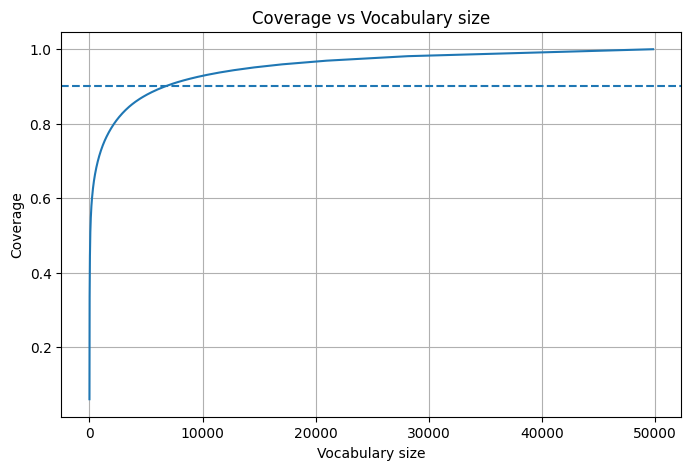

optimal vocab that covers 90% of the dataset: 6671


In [8]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

nltk.download("brown")
from nltk.corpus import brown

# 1. Load corpus
words = [w.lower() for w in brown.words()]
freq = Counter(words)

# sort
freq_sorted = np.array(sorted(freq.values(), reverse=True))

# cumulative coverage (from the formula)
cumulative = np.cumsum(freq_sorted) / np.sum(freq_sorted)

# vocabulary sizes
vocab_sizes = np.arange(1, len(freq_sorted) + 1)
print(f'vocab size: {vocab_sizes}')

# 2. Plot
plt.figure(figsize=(8,5))
plt.plot(vocab_sizes, cumulative)
plt.axhline(0.9, linestyle="--")
plt.xlabel("Vocabulary size")
plt.ylabel("Coverage")
plt.title("Coverage vs Vocabulary size")
plt.grid()
plt.show()

# 3. Find minimal vocab size for 90% coverage
vocab_90 = np.argmax(cumulative >= 0.9) + 1
print(f'optimal vocab that covers 90% of the dataset: {vocab_90}')


## 4. Answer the questions:
1. **Why does the coverage growth slow down?**
Frequent words cover most of the dataset. New words are increasingly rare, so they contribute very little additional coverage (as the features in PCA).

2. **Which law explains this?**
Zipf’s Law - states that in natural language the frequency of a word is inversely proportional to its rank in the frequency table.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [5]:
from collections import defaultdict, Counter
import re
import collections

class BPETokenizer:
    """
    Byte Pair Encoding tokenizer implementation.
    This tokenizer learns merge rules (subword units) from a text corpus.
    """

    def __init__(self, vocab_size):
        # Target number of merge operations (size of learned subword vocabulary)
        self.vocab_size = vocab_size
        
        # List of learned merges. Each merge is a tuple like ('l','o') -> 'lo'
        self.merges = []

    def get_stats(self, vocab):
        """
        Count frequencies of adjacent symbol pairs in the vocabulary.

        vocab format:
        {
            "l o w </w>": 5,
            "l o w e r </w>": 2
        }

        Returns:
            dict { (symbol1, symbol2) : frequency }
        """
        pairs = collections.defaultdict(int)
        # Iterate over each word and its frequency
        for word, freq in vocab.items():
            symbols = word.split()
            # Count all adjacent pairs in the word
            for i in range(len(symbols)-1):
                pairs[symbols[i], symbols[i+1]] += freq

        return pairs

    def merge_vocab(self, pair, v_in):
        """
        Replace the most frequent pair with a merged token in the whole vocabulary.

        Example:
            ('l','o') -> 'lo'
            "l o w </w>" -> "lo w </w>"
        """
        v_out = {}
        # Regex to match the pair as a whole token (avoid partial matches)
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')

        # Replace the pair in every word of the vocabulary
        for word in v_in:
            w_out = p.sub(''.join(pair), word)
            v_out[w_out] = v_in[word]

        return v_out

    def train(self, corpus):
        """
        Train BPE merge rules.

        corpus: list of words from dataset
        """

        # Step 1: Count word frequencies
        vocab = Counter(corpus)
        # Step 2: Convert each word into character-level tokens + end-of-word symbol
        # Example: "low" -> "l o w </w>"
        vocab = {" ".join(list(w)) + " </w>": f for w, f in vocab.items()}
        # Step 3: Iteratively learn merge rules
        while len(self.merges) < self.vocab_size:
            # Count pair frequencies
            pairs = self.get_stats(vocab)

            # Stop if no more pairs exist
            if not pairs:
                break

            # Find most frequent pair
            best = max(pairs, key=pairs.get)
            # Save merge rule
            self.merges.append(best)
            # Apply merge to vocabulary
            vocab = self.merge_vocab(best, vocab)

    def tokenize_word(self, word):
        """
        Apply learned merges to a single word.

        Example:
            "lower" -> ["low", "er", "</w>"]
        """
        # Start from character tokens
        tokens = list(word) + ["</w>"]
        # Apply merges in the order they were learned
        for merge in self.merges:
            i = 0
            while i < len(tokens) - 1:
                # If adjacent tokens match the merge rule -> merge them
                if (tokens[i], tokens[i+1]) == merge:
                    tokens[i:i+2] = ["".join(merge)]
                else:
                    i += 1

        return tokens

    def tokenize(self, sentence):
        """
        Tokenize a full sentence using BPE.
        """
        words = sentence.lower().split()
        tokens = []
        # Tokenize each word separately and concatenate tokens
        for w in words:
            tokens.extend(self.tokenize_word(w))

        return tokens


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [6]:
# prepare sentences and words
sentences = [" ".join(sent) for sent in brown.sents()]
words = [w.lower() for w in brown.words()]

# 90% coverage
vocab_90 = np.argmax(cumulative >= 0.9) + 1

# 1. train tokenizer
tokenizer = BPETokenizer(vocab_size=vocab_90)
tokenizer.train(words)

# take 1000 sentences
sample = sentences[:1000]

fertilities = []  # tokens per word
lengths = []      # tokens per sentence

for sent in sample:
    # Apply BPE tokenization
    tokens = tokenizer.tokenize(sent)
    words = sent.split()
    # Compute fertility for the sentence
    fertility = len(tokens) / len(words)
    
    fertilities.append(fertility)
    lengths.append(len(tokens))

# Aggregate statistics over the sample
print(f'fertility mean: {np.mean(fertilities)}')
print(f'fertility std: {np.std(fertilities)}')
print(f'lengths mean: {np.mean(lengths)}')
print(f'lengths std: {np.std(lengths)}')


fertility mean: 2.313208198957541
fertility std: 0.5446688081292569
lengths mean: 49.866
lengths std: 28.329631907245105


## Conclusion

The coverage experiment showed that a small vocabulary already covers most of the text: about 9k words give ~90% coverage, and adding more words increases coverage very slowly (Zipf’s law).

The trained BPE tokenizer has fertility ≈ 2.31, which means 1 word becomes ~2–3 tokens on average. The average sentence length after tokenization is about 50 tokens, which is roughly 2× longer than the original sentences.

So, BPE solves the OOV (Out-Of-Vocabulary) problem and keeps the vocabulary small, but the trade-off is longer tokenized sequences and higher computation cost.